# Fine-tuning EpiAgent for Reference Data Integration and Query Data Mapping

This notebook provides a comprehensive demo on how to fine-tune the pre-trained **EpiAgent** model (trained on the large-scale **Human-scATAC-Corpus** with approximately 5 million cells and 35 billion tokens) for the integration of reference data and mapping of query data. As previously demonstrated, EpiAgent is capable of extracting cell embeddings that encapsulate cellular heterogeneity from a single dataset. However, in practical applications such as constructing comprehensive cell atlases, cells are often derived from multiple datasets. This can introduce batch effects due to external factors (e.g., differences in sequencing technologies or depths), which result in variations in sequencing data for the same cell types across datasets.

To correct for these batch effects, EpiAgent incorporates a batch-specific token embedding to generate batch-invariant cell embeddings. Once integrated, these corrected cells can serve as reference data. When newly-sequenced data (query data) is introduced, EpiAgent generates cell embeddings that can be directly mapped to the reference dataset using mutual nearest neighbor (MNN) relationships, thereby enabling downstream tasks such as label transfer.

**What You Need to Run This Demo:**

- **Pre-trained EpiAgent Model**: `pretrained_EpiAgent.pth`  
  (Download from: [Google Drive](https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing))

- **Reference Data**: `reference_data_downsampled_10000_cells.h5ad`  
  (Download from: [Google Drive](https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing))  
  **Important**: The dataset features must be based on **cCREs** (candidate cis-regulatory elements). The **cCRE.bed** file is available for reference at: [cCRE.bed](https://github.com/xy-chen16/EpiAgent/blob/main/data/cCRE.bed). This reference dataset has been preprocessed with **global_TFIDF** and **tokenization**. Please note that while this demo uses a preprocessed dataset, you can preprocess your own dataset using the code provided in this notebook.

- **Query Data (Optional)**: `query_data_downsampled_5000_cells.h5ad`  
  (Download from: [Google Drive](https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing))  
  **Important**: Similar to the reference dataset, the query dataset must have features based on **cCREs**. It has also been preprocessed with **global_TFIDF** and **tokenization**. These query cells will be mapped onto the integrated reference data for tasks such as label transfer.

**Additional Note**:  
Please ensure that the reference data includes batch or dataset information stored in the `batch` (or `dataset`) column within its `obs` attribute. This information is essential for the correction of batch effects and proper integration of data from multiple sources.


# Step 1: Data Loading and Preprocessing

In this notebook, the preprocessed **reference dataset** already contains TF-IDF transformation and tokenization (i.e., the `cell_sentences` have been generated). Moreover, the AnnData object includes batch-related labels (stored in the `dataset` column) and cell type labels (stored in the `cell_type` column, though this is optional and primarily for performance validation).

We now proceed with data loading and further preprocessing.

In [1]:
import scanpy as sc

# Load the preprocessed reference dataset
input_path = '../data/sample/processed_h5ad/reference_data_downsampled_10000_cells.h5ad'
reference_adata = sc.read_h5ad(input_path)

# Display basic information about the dataset, especially the obs dataframe to review batch-related annotations.
print(reference_adata)
reference_adata.obs

AnnData object with n_obs × n_vars = 10000 × 1355445
    obs: 'batch', 'cell_type', 'dataset', 'cell_sentences'


,batch,cell_type,dataset,cell_sentences
LL_174.TTGGACCCAGCAGAAGGTTGTT-0,0,Oligodendrocyte,Li2023a,"[611232,161655,332239,572745,749137,1142453,95..."
LL_174.TATAGATCCCCTCAGATAAGGG-0,0,Oligodendrocyte,Li2023a,"[752600,141378,813952,383294,127276,1259096,40..."
MM_900.ACACAGAACACGAGACGTTTAA-0,0,Oligodendrocyte,Li2023a,"[417877,876159,1262432,397930,1353605,197927,4..."
LL_174.TTGTGACATCATGTCGCCTGAA-0,0,Oligodendrocyte,Li2023a,"[223196,54067,1109749,348959,876542,1109724,72..."
LL_174.TGGAGAAGATTTAAACGCGAAG-0,0,Oligodendrocyte,Li2023a,"[1354554,809008,1355413,285528,1342588,1336939..."
...,...,...,...,...
snATAC_Control_C1_MotorCortex#GCTGAGCGTACAAGCG-1-1,1,Oligodendrocyte,Li2023b,"[134480,447410,584279,917284,606165,707238,396..."
snATAC_Control_C3_MotorCortex#GCGGAAATCACAAGCT-1-1,1,Inhibitory neuron,Li2023b,"[708975,1275243,222746,252155,1046563,898971,2..."
snATAC_C9ALS_A6_MotorCortex#CAAGAAATCGCACAAT-1-1,1,Oligodendrocyte,Li2023b,"[223870,1350162,93479,1333387,1083391,443542,6..."
snATAC_C9ALS_A3_MotorCortex#TTCAACTAGTATCTGC-1-1,1,Microglia,Li2023b,"[1239434,966160,1233945,540707,1324344,804301,..."


## Note on Data Preprocessing

In many cases, if you were starting from raw count data, you would need to perform the following preprocessing steps before tokenization:

In [2]:
# from epiagent.tokenization import tokenization
# from epiagent.preprocessing import global_TFIDF
# 
# # Load the cCRE document frequency data
# cCRE_document_frequency = np.load('../data/cCRE_document_frequency.npy')
# 
# # Apply TF-IDF transformation to the raw count matrix
# global_TFIDF(reference_adata, cCRE_document_frequency)
# 
# # Perform tokenization to create cell sentences
# tokenization(reference_adata)

However, in this demo, the dataset has already been preprocessed, and these steps are therefore omitted. Key information in the dataset:
 - The batch information (dataset origin) is stored in the `dataset` column of the obs dataframe.
 - Cell type labels (`cell_type`) are stored in the `cell_type` column and are used for validation (optional).

# Step 2: Extract Zero-shot Cell Embeddings for Batch Matching

In this step, we extract cell embeddings from the reference dataset using the pre-trained **EpiAgent_BC** model with zero-shot conditions. These embeddings will be used for batch matching between different datasets, leveraging batch-specific token embeddings for batch correction. 

**Overview:**
- We first construct a dataset and DataLoader from the reference AnnData (`reference_adata`) using the tokenized cell sentences.
- Next, we load the pre-trained **EpiAgent** model (trained on the large-scale Human-scATAC-Corpus with approximately 5 million cells and 35 billion tokens) using the **EpiAgent_BC** class. This variant introduces a batch-specific token embedding to account for batch effects.
- We then modify the model’s cCRE embedding layer by appending an extra randomly initialized embedding vector.
- Finally, we extract cell embeddings using the `infer_cell_embeddings` function and store them in `reference_adata.obsm['cell_embeddings_zero_shot']`. The UMAP visualization is then performed using the `cell_type` (optional) and `dataset` columns.

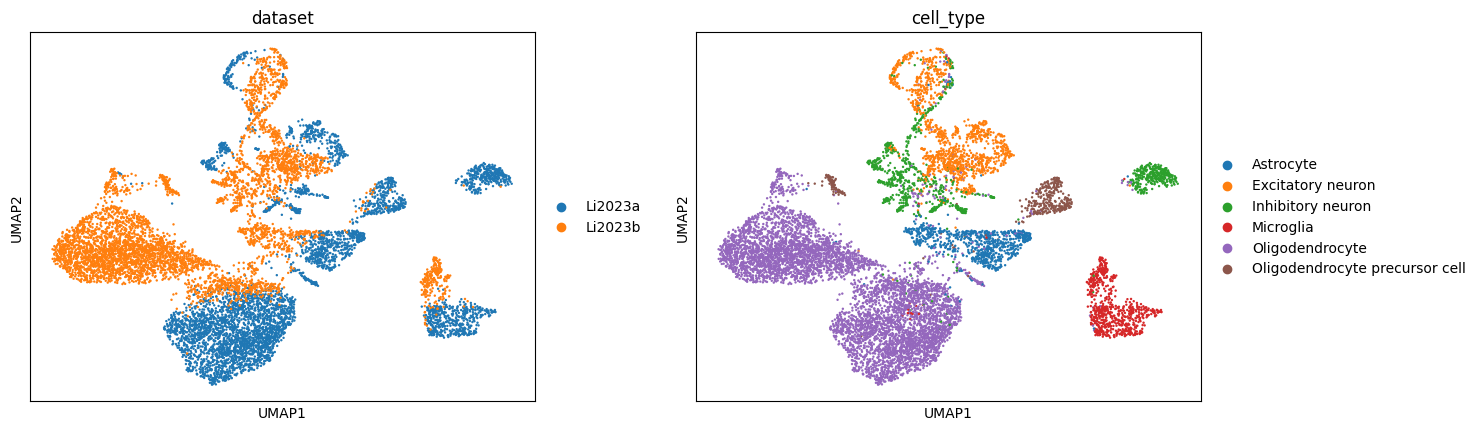

In [3]:
# %% [code]
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import scanpy as sc

# -------------------------
# 1. Construct Dataset and DataLoader for Embedding Extraction
# -------------------------
from epiagent.dataset import CellDataset, collate_fn

# Extract tokenized cell sentences from reference_adata.obs (created in Step 1)
reference_cell_sentences = reference_adata.obs['cell_sentences'].tolist()

# Create the dataset for embedding extraction using the tokenized cell sentences
embedding_dataset = CellDataset(
    cell_sentences=reference_cell_sentences,
    max_length=8192,
    is_random=False
)

# Create the DataLoader with a moderate batch size (e.g., 8)
embedding_dataloader = DataLoader(
    embedding_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# -------------------------
# 2. Load the Pre-trained EpiAgent Model and Modify cCRE Embeddings
# -------------------------
# Use the batch-correction variant of EpiAgent, i.e., EpiAgent_BC.
from epiagent.model import EpiAgent, EpiAgent_BC

# Specify the path to the pre-trained model file.
model_path = '../model/pretrained_EpiAgent.pth'

# Set the computation device (using GPU "cuda:3" if available)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Determine the number of batches present in the reference data.
# It is assumed that the batch (or dataset) information is stored in the 'dataset' column of reference_adata.obs.
unique_batches = reference_adata.obs['dataset'].unique()
batch_num = len(unique_batches)

# Initialize the EpiAgent_BC model with appropriate configurations.
pretrained_model = EpiAgent_BC(
    batch_num=batch_num,
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.),
    pos_weight_for_CCA=torch.tensor(1.)
)

# Load the pre-trained weights into the model.
pretrained_model.load_state_dict(torch.load(model_path), strict=False)
# Ensure the CCA loss uses a positive weight of 1.
pretrained_model.criterion_CCA.pos_weight = torch.tensor(1.)

# **Modification: Add an extra embedding to the cCRE_embedding layer.**
original_weight = pretrained_model.cCRE_embedding.weight.data  # Shape: [num_embeddings, embedding_dim]
new_embedding = torch.randn(1, original_weight.shape[1]) * 0.01  # Random initialization
new_weight = torch.cat([original_weight, new_embedding], dim=0)  # Concatenate along vocabulary dimension
pretrained_model.cCRE_embedding = nn.Embedding(new_weight.shape[0], new_weight.shape[1])
pretrained_model.cCRE_embedding.weight.data = new_weight

# Move the model to the specified device.
pretrained_model.to(device)

# -------------------------
# 3. Extract Cell Embeddings Using the Zero-shot Model
# -------------------------
from epiagent.inference import infer_cell_embeddings

# Use the infer_cell_embeddings function to generate cell embeddings for the reference dataset.
cell_embeddings = infer_cell_embeddings(pretrained_model, device, embedding_dataloader)

# Assign the extracted embeddings to the reference AnnData object.
reference_adata.obsm['cell_embeddings_zero_shot'] = cell_embeddings

# -------------------------
# 4. UMAP Visualization of the Extracted Embeddings
# -------------------------
# Construct the neighbor graph and UMAP based on the extracted embeddings.
sc.pp.neighbors(reference_adata, use_rep='cell_embeddings_zero_shot')
sc.tl.umap(reference_adata)

# Plot UMAP visualization, coloring the cells by 'cell_type' (if available) and 'dataset'.
sc.pl.umap(reference_adata, color=['dataset', 'cell_type'],wspace=0.2)

# Step 3: Process AnnData via OT Matching and Construct Datasets & Dataloaders for RDI

In this step, we:
1. **Perform Optimal Transport (OT) Matching** between cells from different batches. We use the zero-shot cell embeddings from `reference_adata` to perform OT matching, ensuring cells from different batches are aligned based on their embeddings.
   - The function `generate_adata_for_RDI` (imported from `epiagent.utils`) processes the input `reference_adata` and returns an expanded AnnData with a new batch label, indicating that cells from different batches are now mapped using OT.
2. **Modify the `dataset` column**: After OT matching, we ensure that the `batch_ids` column in both the original and the processed `AnnData` is updated to reflect the batch information for all cells.
3. **Construct a training dataset** using the `CellDatasetForRDI` class.
4. **Construct a test dataset** using the `TestCellDatasetForRDI` class for evaluation.


In [4]:
from epiagent.utils import generate_adata_for_RDI
from epiagent.dataset import CellDatasetForRDI, TestCellDatasetForRDI, collate_fn_for_RDI, collate_fn_for_RDI_test
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder

# --------------------------
# Process Training AnnData with OT Matching for RDI
# --------------------------
# Perform OT matching on the reference data (reference_adata) using the zero-shot embeddings
new_reference_adata = generate_adata_for_RDI(
    adata=reference_adata, 
    cell_embedding_key="cell_embeddings_zero_shot", 
    batch_label="dataset"
)
# new_reference_adata now contains expanded metadata, with the cells mapped and new batch labels

# --------------------------
# Process batch labels (dataset column) and update batch_ids
# --------------------------
# Label encoding for the batch information
batch_encoder = LabelEncoder()
reference_adata.obs['batch_ids'] = batch_encoder.fit_transform(reference_adata.obs['dataset'].tolist())
new_reference_adata.obs['batch_ids'] = batch_encoder.transform(new_reference_adata.obs['dataset'].tolist())

# --------------------------
# Construct the Training Dataset and DataLoader for RDI
# --------------------------
# Extract the necessary information from the new_reference_adata
train_cell_sentences = new_reference_adata.obs['cell_sentences'].tolist()
train_predicted_cell_sentences = new_reference_adata.obs['predicted_cell_sentences'].tolist()
train_batch_ids = new_reference_adata.obs['batch_ids'].tolist()

# Create the training dataset using the RDI dataset class
train_dataset = CellDatasetForRDI(
    adata=new_reference_adata,
    cell_sentences=train_cell_sentences,
    predicted_cell_sentences=train_predicted_cell_sentences,
    max_length=8192,
    alpha_for_CCA=1,
    num_cCRE=1355445,
    is_random=False,
    batch_ids=train_batch_ids
)

# Create the DataLoader for training
train_batch_size = 5
train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=16,
    collate_fn=collate_fn_for_RDI
)

# --------------------------
# Construct the Test Dataset and DataLoader for RDI
# --------------------------
# Extract the necessary information from the reference_adata for testing
test_cell_sentences = reference_adata.obs['cell_sentences'].tolist()
test_batch_ids = reference_adata.obs['batch_ids'].tolist()

# Create the test dataset using the TestCellDatasetForRDI class
test_dataset = TestCellDatasetForRDI(
    cell_sentences=test_cell_sentences,
    max_length=8192,
    is_random=False,
    batch_ids=test_batch_ids
)

# Create the test DataLoader
test_batch_size = 8
test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn_for_RDI_test
)

# For debugging: print dataset sizes
print("Training dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))


/home/chenxiaoyang/program/scCASdata/Big model/epiagent/utils.py:339: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_adata = selected_adata_A.concatenate(selected_adata_B)
/home/chenxiaoyang/program/scCASdata/Big model/epiagent/utils.py:351: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  final_adata = final_adata.concatenate(combined_adata)


Training dataset size: 14500
Test dataset size: 10000


# Step 4: Fine-tune EpiAgent Model for Reference Data Integration (RDI)

In this step, we fine-tune the pre-trained **EpiAgent_BC** model for reference data integration. The goal is to generate batch-invariant cell embeddings that can be used for downstream integration tasks, such as merging data from multiple batches or transferring labels across datasets. In real-world applications, reference data are often collected from different batches or experimental conditions, leading to batch effects. To address this, the **EpiAgent_BC** variant incorporates a batch-specific token embedding and is fine-tuned with a dual-objective approach:

1. **Cell-cCRE Alignment and Signal Reconstruction**:  
   The model is optimized to learn the intrinsic accessibility patterns of cells by minimizing the Cell-cCRE Alignment (CCA) and Signal Reconstruction (SR) losses. This ensures that the regulatory landscape is accurately captured, regardless of batch-specific biases.

2. **Adversarial Batch Discrimination**:  
   A classifier model is employed as a discriminator to encourage the generation of batch-invariant embeddings. The classifier is trained to predict the batch (as defined by the `dataset` column) from the cell embeddings, while the main model is adversarially optimized to confuse the classifier. In practice, this is implemented in two stages within each training step:
   - **Stage 1**: Freeze the main model and update only the classifier (using its own optimizer) based on the classification loss computed from the [CLS] token of the transformer outputs.
   - **Stage 2**: Freeze the classifier and update the main model using a combined loss comprising the CCA loss, SR loss, and a negative (adversarial) component of the classification loss (weighted by 0.01). This encourages the model to produce embeddings that are less distinguishable by batch.

The classifier is initialized with a number of output classes equal to the number of unique batches present in the reference dataset (extracted from the `dataset` column). The following code snippet demonstrates the initialization of the classifier model and the commencement of fine-tuning using the `fine_tune_epiagent_for_RDI` function.

In [5]:
from epiagent.model import classifier
from epiagent.train import fine_tune_epiagent_for_RDI

# Initialize the classifier model
classifier_model = classifier(embedding_dim=512, num_classes=len(reference_adata.obs['dataset'].unique()))

# Fine-tune the model for RDI prediction
fine_tuned_model = fine_tune_epiagent_for_RDI(
    model=pretrained_model,
    classifier_model=classifier_model,
    train_dataloader=train_dataloader,
    num_steps=200000,
    save_dir='../model/fine_tune/RDI/demo_dataset/',
    device=device,
    learning_rate=5e-4,
    save_steps=50000,
    log_steps=1000,
    warmup_steps=30000,
    is_logging=True
)

Model directory created at: ../model/fine_tune/RDI/demo_dataset/


Epoch [1/68], Step [1000/2900], Total Loss: 0.9716, CCA Loss: 0.5210, SR Loss: 0.4557, Class Loss: 0.0511 (w=0.1), Classification Accuracy: 0.9176
CCA Metrics - Positive Acc: 0.6482, Negative Acc: 0.7874, AUROC: 0.7950, AUPRC: 0.8189
Epoch [1/68], Step [2000/2900], Total Loss: 0.9771, CCA Loss: 0.5221, SR Loss: 0.4567, Class Loss: 0.0166 (w=0.1), Classification Accuracy: 0.9794
CCA Metrics - Positive Acc: 0.5459, Negative Acc: 0.8313, AUROC: 0.7504, AUPRC: 0.7751
End of Epoch 1/68, Total Loss: 2814.7654, CCA Loss: 1507.3312, SR Loss: 1308.2115, Class Loss: 77.7252
Epoch [2/68], Step [100/2900], Total Loss: 0.9545, CCA Loss: 0.5157, SR Loss: 0.4399, Class Loss: 0.0110 (w=0.1), Classification Accuracy: 0.9874
CCA Metrics - Positive Acc: 0.7326, Negative Acc: 0.8748, AUROC: 0.8659, AUPRC: 0.8785
Epoch [2/68], Step [1100/2900], Total Loss: 0.9453, CCA Loss: 0.5130, SR Loss: 0.4333, Class Loss: 0.0111 (w=0.1), Classification Accuracy: 0.9846
CCA Metrics - Positive Acc: 0.7195, Negative Acc:

# Step 5: Perform Inference Using the Fine-tuned EpiAgent_BC Model for Reference Data Integration (RDI)

After fine-tuning the **EpiAgent_BC** model in **Step 4**, we now proceed with performing inference to extract cell embeddings for the reference data integration (RDI) task. In this step, the goal is to predict the embeddings for cells in the reference dataset after fine-tuning the model. This will allow us to use the batch-invariant embeddings for downstream integration tasks.

We will focus on extracting cell embeddings for all batches in the reference dataset. The model has been fine-tuned to produce embeddings that are invariant to batch effects by incorporating batch-specific token embeddings. These embeddings can now be used to align and integrate data from multiple batches.

Since the model is batch-aware, we need to provide both the cell sentences and the batch IDs as inputs to the model. The batch IDs allow the model to distinguish between different batches, ensuring that embeddings are generated accordingly. These embeddings will be stored in the `reference_adata.obsm['cell_embeddings_fine_tuned_BC']` field.


In [6]:
import numpy as np
from epiagent.inference import infer_cell_embeddings_for_RDI

# Step 1: Perform inference using the fine-tuned EpiAgent_BC model for RDI.
# Use the test_dataloader to fetch batches from the reference dataset.
# The dataloader should include both the cell sentences and the batch IDs.

cell_embeddings_fine_tuned = infer_cell_embeddings_for_RDI(
    model=fine_tuned_model,  # The fine-tuned EpiAgent_BC model
    device=device,
    dataloader=test_dataloader  # The dataloader for the reference dataset
)

# Step 2: Store the generated embeddings in the AnnData object.
# These embeddings will be used for reference data integration.
reference_adata.obsm['cell_embeddings_fine_tuned_BC'] = cell_embeddings_fine_tuned

# Step 6: Visualizing Fine-tuned EpiAgent_BC Performance for Reference Data Integration

In this step, we will visualize the performance of the fine-tuned **EpiAgent_BC** model for reference data integration (RDI). The goal is to evaluate how well the model has integrated data from different batches by comparing the embeddings generated at various stages:

1. **Zero-shot Embeddings** (initial embeddings before fine-tuning).
2. **PCA + UMAP of Top 50,000 cCREs** (used for reference data integration).
3. **Fine-tuned Embeddings** (post fine-tuning with batch-specific embeddings).

We will generate three sets of UMAP plots to visualize how well the embeddings from different models (zero-shot, PCA+UMAP, and fine-tuned) are organized in terms of `cell_type` and `dataset`.


... storing 'type' as categorical


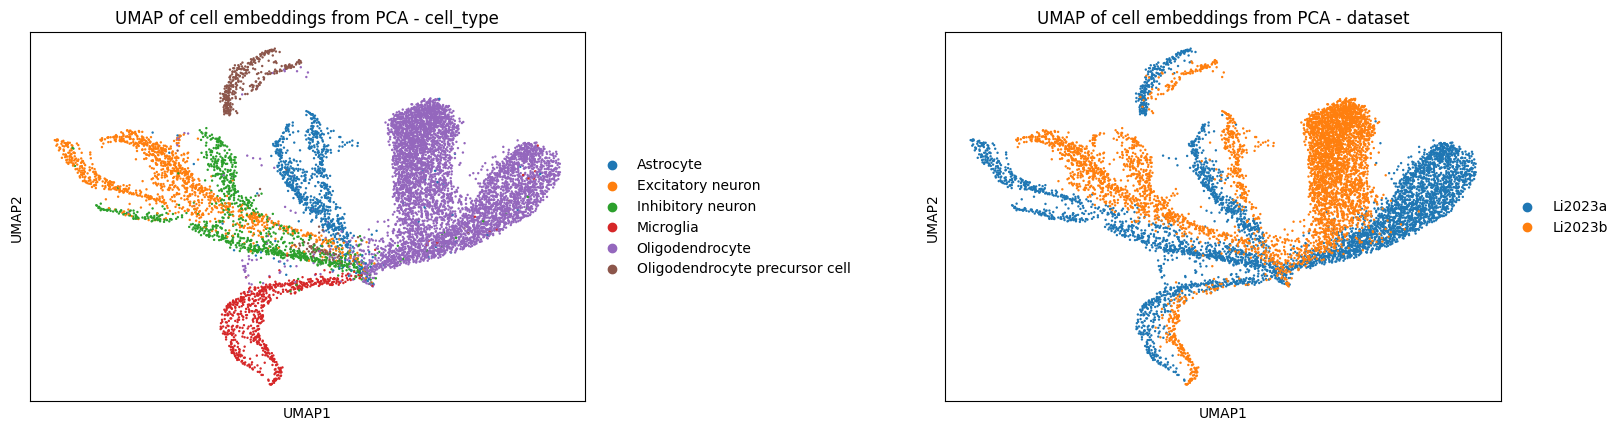

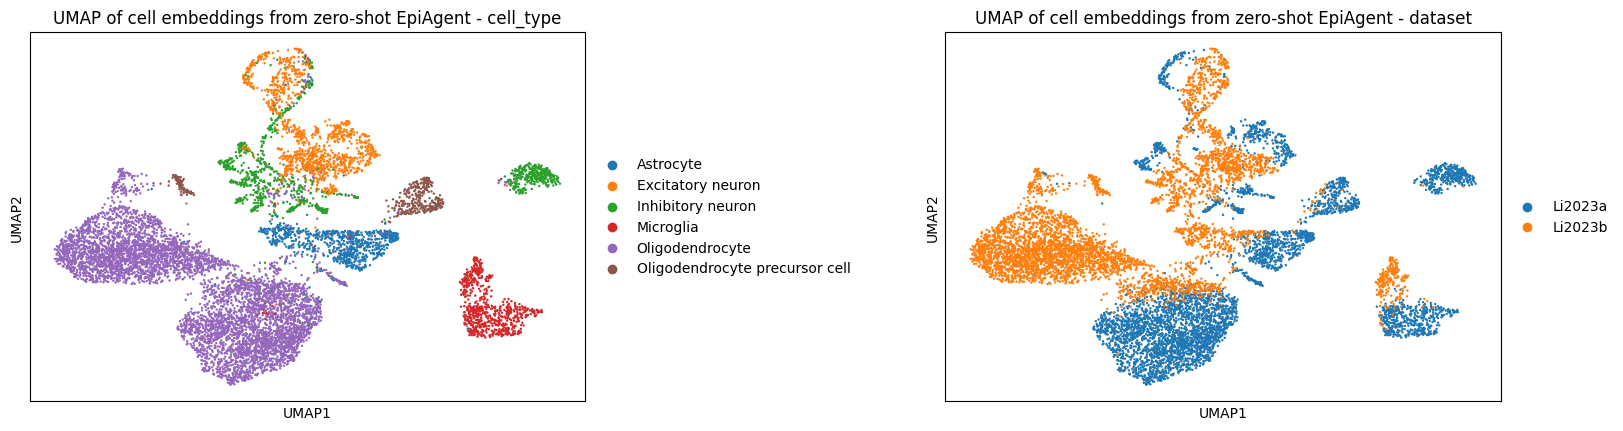

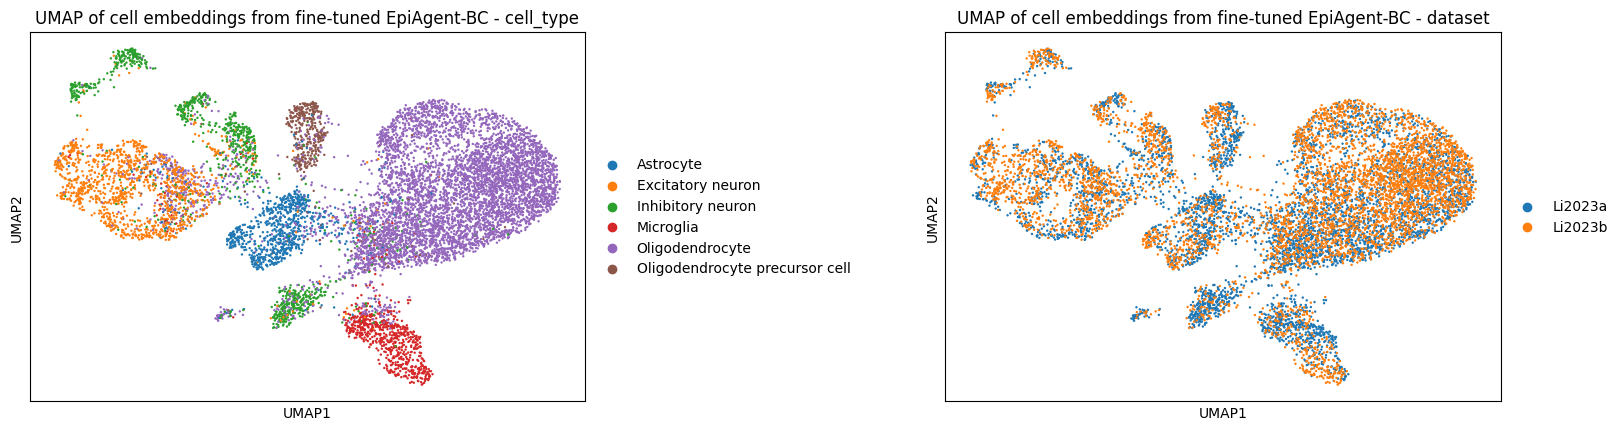

In [18]:
import scanpy as sc
import numpy as np

# Step 1: Store UMAP for Zero-shot Embeddings in `obsm`
# We assume UMAP has already been computed earlier.
sc.pp.neighbors(reference_adata, use_rep='cell_embeddings_zero_shot')
sc.tl.umap(reference_adata)
reference_adata.obsm['X_umap_cell_embeddings_zero_shot'] = reference_adata.obsm['X_umap']

# Step 2: Filter for the top 50,000 most accessible cCREs based on chromatin accessibility.
# Convert adata.X to dense if it is sparse and compute the top 50,000 most accessible cCREs.
cCRE_accessibility = np.array(reference_adata.X.sum(axis=0)).squeeze()
top_50000_indices = np.argsort(cCRE_accessibility)[-50000:]

# Filter for the top 50,000 cCREs in `reference_adata` using the indices
filtered_reference_adata = reference_adata[:, top_50000_indices].copy()

# Perform PCA and UMAP on the top 50,000 cCREs
sc.tl.pca(filtered_reference_adata, n_comps=50)
sc.pp.neighbors(filtered_reference_adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(filtered_reference_adata)

# Store UMAP results in `obsm`
reference_adata.obsm['X_umap_cell_embeddings_pca'] = filtered_reference_adata.obsm['X_umap']

# Step 3: Perform UMAP on the fine-tuned cell embeddings (cell_embeddings_fine_tuned_BC).
sc.pp.neighbors(reference_adata, use_rep='cell_embeddings_fine_tuned_BC')
sc.tl.umap(reference_adata)

# Store UMAP results in `obsm`
reference_adata.obsm['X_umap_cell_embeddings_fine_tuned_BC'] = reference_adata.obsm['X_umap']

# Step 4: Visualization
# Define a function to create UMAP plots with `cell_type` and `dataset` colorings.
def plot_umap(adata, key, title="UMAP Visualization"):
    """
    Function to visualize UMAP results with colorings for `cell_type` and `dataset`.

    Args:
        adata (AnnData): The annotated data object with UMAP results.
        key (str): The key in `obsm` for UMAP results to plot.
        title (str or list of str): The title for the UMAP plots. If a single string is provided,
            it will be used to generate sub-titles for each subplot.
    
    Returns:
        None: Displays UMAP plots.
    """
    adata.obsm['X_umap'] = adata.obsm[key]
    # If a single title string is provided, convert it to a list for both subplots.
    if isinstance(title, str):
        titles = [f"{title} - cell_type", f"{title} - dataset"]
    else:
        titles = title
    sc.pl.umap(adata, color=['cell_type', 'dataset'], wspace=0.5, title=titles)

# Step 5: Create UMAP plots for the three embeddings
# Visualize UMAP for PCA-based embeddings
plot_umap(reference_adata, 'X_umap_cell_embeddings_pca', title="UMAP of cell embeddings from PCA")

# Visualize UMAP for Zero-shot embeddings
plot_umap(reference_adata, 'X_umap_cell_embeddings_zero_shot', title="UMAP of cell embeddings from zero-shot EpiAgent")

# Visualize UMAP for Fine-tuned embeddings (Batch-corrected)
plot_umap(reference_adata, 'X_umap_cell_embeddings_fine_tuned_BC', title="UMAP of cell embeddings from fine-tuned EpiAgent-BC")


# Step 7: Query Data Mapping (Optional)

In this step, we demonstrate how to map query data onto the integrated reference dataset using the fine-tuned **EpiAgent_BC** model. Mapping the query data enables downstream analyses such as label transfer by aligning the query cell embeddings with the reference embeddings. 

**What You Need for Query Data Mapping:**

- **Query Data (Optional)**: `query_data_downsampled_5000_cells.h5ad`  
  (Download from: [Google Drive](https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing))  
  **Important**: Similar to the reference dataset, the query dataset must have features based on **cCREs** (candidate cis-regulatory elements) and has been preprocessed with **global_TFIDF** and **tokenization**.

In [15]:
query_path = '../data/sample/processed_h5ad/query_data_downsampled_5000_cells.h5ad'
query_adata = sc.read_h5ad(query_path)

## Note on Data Preprocessing

In many cases, if you were starting from raw count data, you would need to perform the following preprocessing steps before tokenization:


In [16]:
# from epiagent.tokenization import tokenization
# from epiagent.preprocessing import global_TFIDF
#
# # Load the cCRE document frequency data
# cCRE_document_frequency = np.load('../data/cCRE_document_frequency.npy')
#
# # Apply TF-IDF transformation to the raw count matrix
# global_TFIDF(query_adata, cCRE_document_frequency)
#
# # Perform tokenization to create cell sentences
# tokenization(query_adata)

Next, we use the fine-tuned **EpiAgent_BC** model to extract cell embeddings from the query data (without applying batch-specific token embeddings), and store these embeddings in `query_adata.obsm['cell_embeddings_fine_tuned_BC']`. We then add a new `type` column to both the reference and query datasets, combine them, and finally compute and visualize UMAP embeddings on the integrated data. The UMAP plots will be colored by `type` (reference vs. query), `dataset`, and `cell_type`.

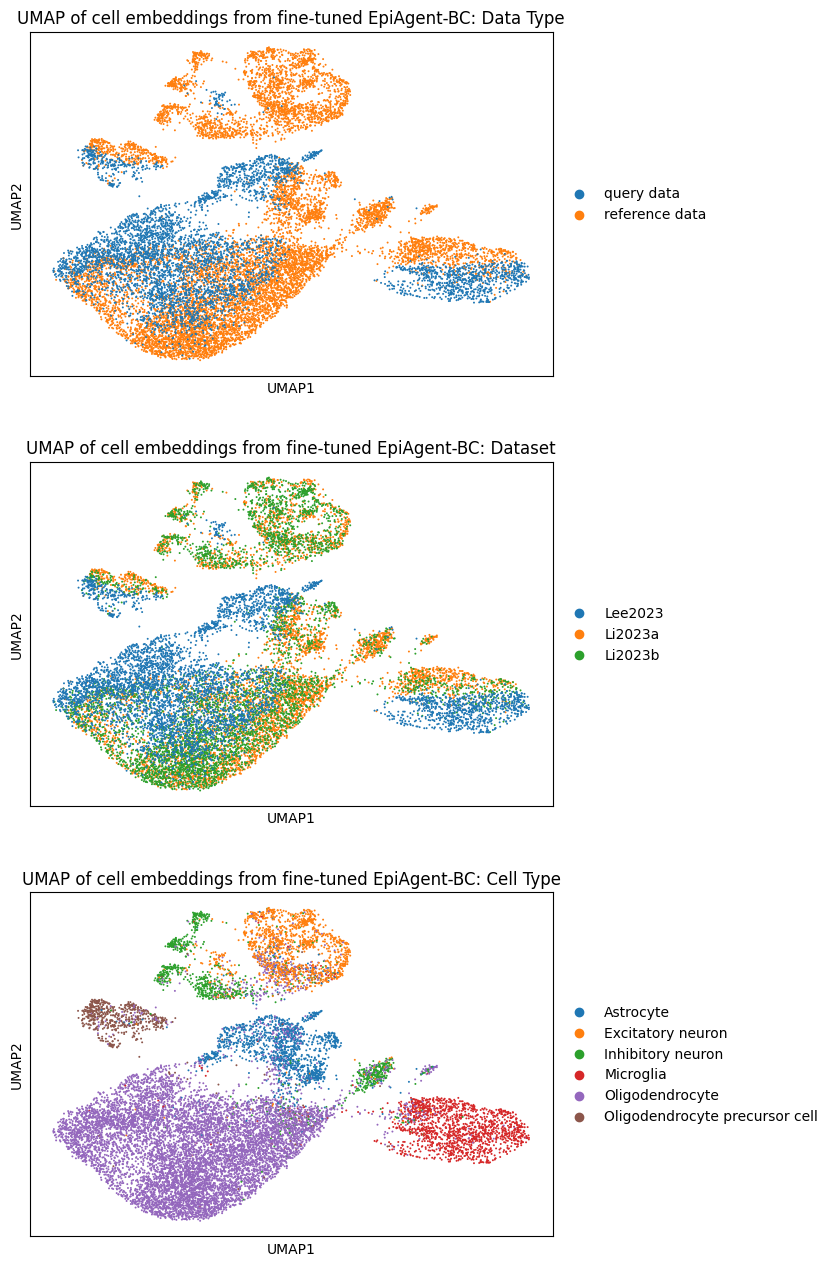

In [20]:
query_cell_sentences = query_adata.obs['cell_sentences'].tolist()

query_dataset = CellDataset(
    cell_sentences=query_cell_sentences,
    max_length=8192,
    is_random=False
)

query_dataloader = DataLoader(
    query_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# --------------------------
# Extract Query Cell Embeddings Using the Fine-tuned Model
# --------------------------
query_cell_embeddings = infer_cell_embeddings(fine_tuned_model, device, query_dataloader)

# Store the extracted embeddings in the query AnnData object
query_adata.obsm['cell_embeddings_fine_tuned_BC'] = query_cell_embeddings

# --------------------------
# Label the Datasets and Combine Them
# --------------------------
# Add a new 'type' column to differentiate reference and query data.
reference_adata.obs['type'] = 'reference data'
query_adata.obs['type'] = 'query data'

# Combine the reference and query datasets into one integrated AnnData object.
integrated_adata = sc.concat([reference_adata, query_adata], join='outer', label='source', keys=['reference', 'query'])

# --------------------------
# Compute UMAP on the Combined Data Using Fine-tuned Embeddings
# --------------------------
# Use the fine-tuned embeddings stored in 'cell_embeddings_fine_tuned_BC'
sc.pp.neighbors(integrated_adata, use_rep='cell_embeddings_fine_tuned_BC')
sc.tl.umap(integrated_adata)

# --------------------------
# Visualize the Integrated UMAP
# --------------------------
# Plot UMAP with colorings for 'type', 'dataset', and 'cell_type'
sc.pl.umap(integrated_adata, color=['type', 'dataset', 'cell_type'], 
           title=["UMAP of cell embeddings from fine-tuned EpiAgent-BC: Data Type", 
                  "UMAP of cell embeddings from fine-tuned EpiAgent-BC: Dataset", 
                  "UMAP of cell embeddings from fine-tuned EpiAgent-BC: Cell Type"],
           ncols=1)

## Label transfer after query data mapping

After obtaining the integrated reference and query data, you can call the `label_transfer_for_QDM` function as shown below to perform label transfer on the query data. Then, UMAP visualization of the query data can be performed using Scanpy's built-in functions.


... storing 'predicted_label_L2_k20' as categorical
... storing 'predicted_label_cosine_k20' as categorical


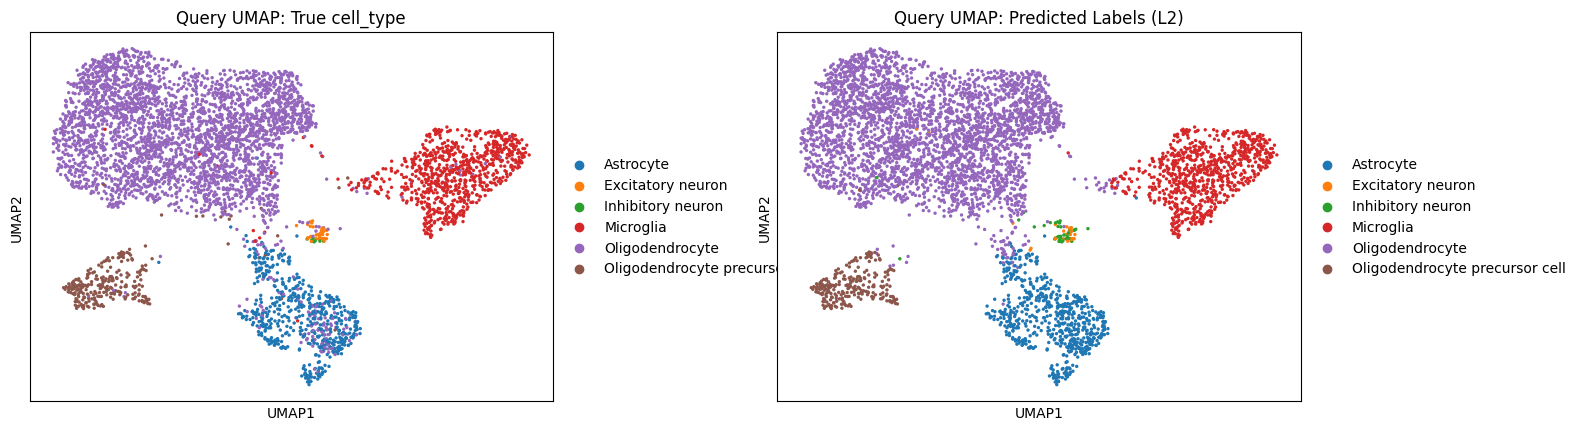

In [23]:
from epiagent.utils import label_transfer_for_QDM

# Perform label transfer using the fine-tuned embeddings.
# This function returns the query_data with transferred labels.
query_data_with_labels = label_transfer_for_QDM(
    integrated_adata=integrated_adata,
    embedding_key='cell_embeddings_fine_tuned_BC',  # Default embedding key for fine-tuned BC embeddings
    k=20,
    source_key='type',
    source_values=['reference data', 'query data'],
    cell_type_key='cell_type'
)

# Visualize the query data embeddings using UMAP.
sc.pp.neighbors(query_data_with_labels, use_rep='cell_embeddings_fine_tuned_BC')
sc.tl.umap(query_data_with_labels)

# Plot UMAP showing the true cell_type and the predicted labels (L2-based as an example).
sc.pl.umap(query_data_with_labels, color=['cell_type', 'predicted_label_L2_k20'], wspace=0.3,
           title=["Query UMAP: True cell_type", "Query UMAP: Predicted Labels (L2)"])